In [ ]:
!pip install optuna

In [ ]:
!git clone https://github.com/gauthiercaceres/bike_counters.git

Cloning into 'bike_counters'...
remote: Enumerating objects: 104, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 104 (delta 34), reused 34 (delta 34), pack-reused 57 (from 1)
Receiving objects: 100% (104/104), 1.25 MiB | 3.25 MiB/s, done.
Resolving deltas: 100% (42/42), done.


In [ ]:
%cd bike_counters

/content/bike_counters


In [ ]:
# Data handling and preprocessing
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
import joblib

# Hyperparameter tuning - for GridSearchCV and RandomizedSearchCV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# For warnings suppression (if needed)
import warnings
warnings.filterwarnings('ignore')

import importlib
import external_data.example_estimator
importlib.reload(external_data.example_estimator)
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
# import optuna
import numpy as np
# import optuna.visualization as vis

In [ ]:

data = pd.read_parquet(Path("data") / "train.parquet")
original_features = data.columns.tolist()
data = external_data.example_estimator._merge_external_data(data)

data = external_data.example_estimator._encode_dates(data)

external_features = [col for col in data.columns if col not in original_features]

for column in data.columns:
    if data[column].isnull().any():
        if data[column].dtype in ['float64', 'int64']:  # Numeric columns
            data[column].fillna(data[column].mean(), inplace=True)  # Fill with mean
        elif data[column].dtype == 'object':  # String columns
            data[column].fillna(data[column].mode()[0], inplace=True)  # Fill with mode

numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
external_numeric_features = [col for col in external_features if col in numeric_columns]


correlation_matrix = data[numeric_columns].corr()

correlation_with_target = correlation_matrix["log_bike_count"].loc[external_numeric_features].sort_values(ascending=False)

top_external_features = correlation_with_target.index[:10].tolist()

required_columns = ['month']  # Add any other essential columns here
selected_features = list(set(original_features + top_external_features + required_columns))
if 'date' in selected_features:
    selected_features.remove('date')


data = data[selected_features]

data['season'] = data['month'].apply(lambda x: 1 if x in [12, 1, 2] else
                                                 2 if x in [3, 4, 5] else
                                                 3 if x in [6, 7, 8] else 4)
print(selected_features)
print(data.columns)

print("Information about the dataset:")
print(data.info())

print("\nVerification of data types and missing values:")
print(data.isnull().sum())
print(data.describe())

print(
    f"\nThere are {data.shape[0]} observations and {data.shape[1]} features."
    "There are no missing values. The target variable is log_count_bike."
)

<ipython-input-3-c6924b8750dc>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[column].fillna(data[column].mean(), inplace=True)  # Fill with mean


['rafper', 'latitude', 'raf10', 'counter_installation_date', 'ff', 'td', 'counter_technical_id', 'longitude', 'ctype1', 'month', 'site_id', 't', 'bike_count', 'site_name', 'cod_tend', 'coordinates', 'counter_name', 'tn12', 'tx12', 'counter_id', 'cl', 'log_bike_count']
Index(['rafper', 'latitude', 'raf10', 'counter_installation_date', 'ff', 'td',
       'counter_technical_id', 'longitude', 'ctype1', 'month', 'site_id', 't',
       'bike_count', 'site_name', 'cod_tend', 'coordinates', 'counter_name',
       'tn12', 'tx12', 'counter_id', 'cl', 'log_bike_count', 'season'],
      dtype='object')
Information about the dataset:
<class 'pandas.core.frame.DataFrame'>
Index: 496827 entries, 107 to 496826
Data columns (total 23 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   rafper                     496827 non-null  float64       
 1   latitude                   496827 non-null  float64       
 2   ra

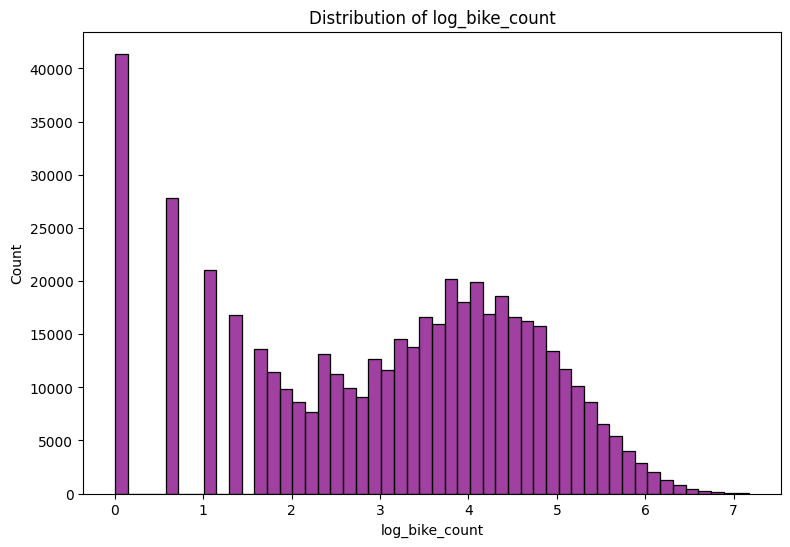

We observe that the target is not evenly distributed but has two peaks around the value 0 and 4.


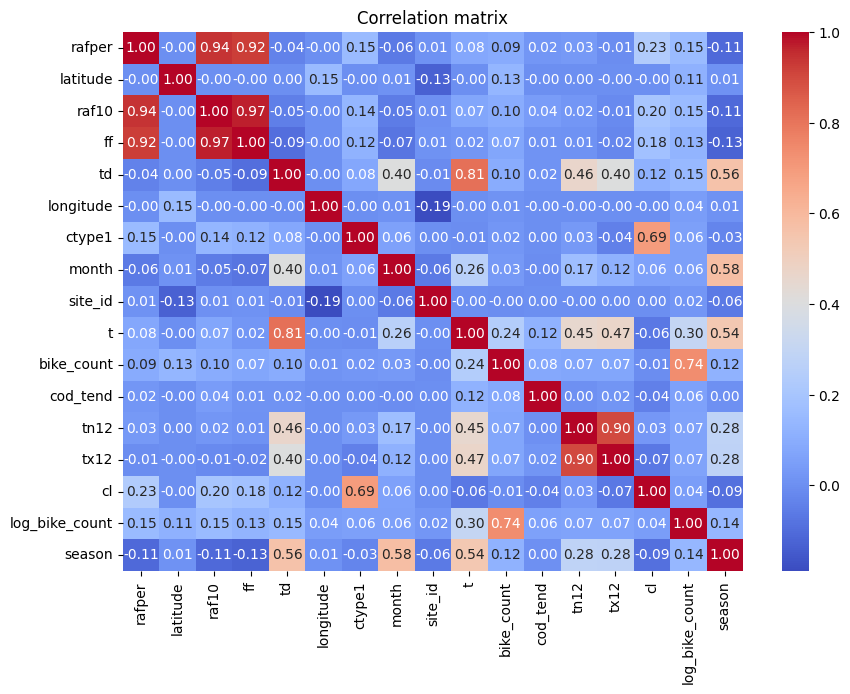


We observe that the target is mainly correlated with the variables hour, season and latitude


In [ ]:
## Exploratory Data Analysis

#import ydata_profiling
#data.profile_report()

#target distribution
plt.figure(figsize=(9,6))
sns.histplot(data['log_bike_count'], bins=50, color='purple')
plt.title('Distribution of log_bike_count')
plt.show()
print("We observe that the target is not evenly distributed but has two peaks around the value 0 and 4.")

#study of the correlation between variables
numercic_cols = data.select_dtypes(include=[np.number]).columns
corr_matrix = data[numercic_cols].corr()
plt.figure(figsize=(10,7))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation matrix')
plt.show()
print(
    "\nWe observe that the target is mainly correlated with the variables hour, season and latitude"
      )




In [ ]:
data.columns

Index(['counter_id', 'cod_tend', 'site_name', 'td', 'rafper', 'site_id',
       'coordinates', 'tn12', 'longitude', 't', 'raf10', 'latitude', 'ff',
       'ctype1', 'counter_installation_date', 'cl', 'bike_count',
       'log_bike_count', 'tx12', 'counter_name', 'counter_technical_id',
       'month', 'season'],
      dtype='object')

In [ ]:
data['counter_id'].nunique()

56

In [ ]:
data['site_id'].nunique()

30

In [ ]:
data.head(2)

,counter_id,cod_tend,site_name,td,rafper,site_id,coordinates,tn12,longitude,t,...,ctype1,counter_installation_date,cl,bike_count,log_bike_count,tx12,counter_name,counter_technical_id,month,season
107,100007049-102007049,8,28 boulevard Diderot,282.55,3.1,100007049,"48.846028,2.375429",282.281494,2.375429,285.75,...,5.823816,2013-01-18,30.0,0.0,0.000000,288.764043,28 boulevard Diderot E-O,Y2H15027244,9,4
153,100007049-102007049,6,28 boulevard Diderot,282.05,1.5,100007049,"48.846028,2.375429",282.281494,2.375429,283.95,...,5.823816,2013-01-18,30.0,1.0,0.693147,288.764043,28 boulevard Diderot E-O,Y2H15027244,9,4


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
# from optuna.samplers import TPESampler

# Séparer les variables cibles et explicatives
X = data.drop(columns=['log_bike_count', 'bike_count'])
y = data['log_bike_count']
# Example usage: Apply preprocessing to the training data
# Diviser les données en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Label encoding for categorical columns
def label_encode_columns(data, categorical_columns, label_encoders=None):
    if label_encoders is None:
        label_encoders = {}
        for col in categorical_columns:
            le = LabelEncoder()
            data[col] = le.fit_transform(data[col])
            label_encoders[col] = le
    else:
        for col in categorical_columns:
            le = label_encoders[col]
            data[col] = le.transform(data[col])  # Use existing encoder for test data
    return data, label_encoders

# Data preprocessing: Scale numeric features and label encode categorical ones
def preprocess_data(data, categorical_columns, numeric_columns, label_encoders=None, scaler=None):
    # Label encode categorical columns
    data, label_encoders = label_encode_columns(data, categorical_columns, label_encoders)

    # Scale numeric columns
    if scaler is None:
        scaler = StandardScaler()
        data[numeric_columns] = scaler.fit_transform(data[numeric_columns])
    else:
        data[numeric_columns] = scaler.transform(data[numeric_columns])  # Use the same scaler for test data

    return data, label_encoders, scaler


In [45]:
def preprocess_final_test_data(final_test_data, categorical_columns, numeric_columns, label_encoders, scaler):
    # Preprocess final test data using saved label encoders and scaler
    final_test_data_processed, _ , _ = preprocess_data(final_test_data, categorical_columns, numeric_columns, label_encoders, scaler)
    return final_test_data_processed

import joblib

def make_predictions_on_final_test(final_test_data, stacking_model_path):
    # Load the stacking model from the .pkl file
    stacking_model = joblib.load(stacking_model_path)

    # Make predictions on the final test data using the stacking model
    final_predictions = stacking_model.predict(final_test_data)

    return final_predictions



In [ ]:
def create_submission_file(final_test_data, final_predictions):
    # Create a DataFrame to store the predictions and other necessary columns
    results_df = pd.DataFrame({
        'id': final_test_data.index,  # Assuming 'id' is the index of the test data
        'log_bike_count': final_predictions  # Predictions from the stacking model
    })

    # Save the results to a CSV file for submission
    results_df.to_csv('submission.csv', index=False)

In [ ]:
# Hyperparameter grids for each model
param_grids = {
    'RandomForest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [5, 10, 15],
        'min_samples_split': [2, 5, 10]
    },
    'XGBRegressor': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [3, 5, 10],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.7, 0.8, 0.9]
    },
    'Ridge': {
        'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]
    }
}

# Create a RandomizedSearchCV to find best hyperparameters
def create_tuned_model(model_type, X_train, y_train, param_grid):
    if model_type == 'RandomForest':
        model = RandomForestRegressor(random_state=42)
    elif model_type == 'XGBRegressor':
        model = XGBRegressor(random_state=42)
    elif model_type == 'Ridge':
        model = Ridge()

    # Use RandomizedSearchCV for hyperparameter tuning
    search = RandomizedSearchCV(model, param_grid, n_iter=10, cv=3, scoring='neg_root_mean_squared_error', random_state=42)
    search.fit(X_train, y_train)

    return search.best_estimator_, search.best_params_

# Train all models
def train_models(X_train, y_train, param_grids):
    models = {}

    for model_type, param_grid in param_grids.items():
        best_model, best_params = create_tuned_model(model_type, X_train, y_train, param_grid)
        models[model_type] = {
            'model': best_model,
            'params': best_params
        }

    return models


In [ ]:
# Create a Stacking Regressor model
def create_stacking_ensemble(models):
    # Base models for stacking
    base_models = [
        ('RandomForest', models['RandomForest']['model']),
        ('XGBRegressor', models['XGBRegressor']['model'])
    ]

    # Create stacking regressor with Ridge as the final estimator
    stacking_model = StackingRegressor(
        estimators=base_models,
        final_estimator=Ridge(),
        cv=5
    )

    return stacking_model


In [37]:
# Load the training data

def full_workflow(train_data,y, test_data, categorical_columns, numeric_columns):
    # Preprocess training data
    X_train = train_data[categorical_columns + numeric_columns]
    y_train = y  # Target column

    X_train_processed, label_encoders, scaler = preprocess_data(X_train, categorical_columns, numeric_columns)

    # Split data into train/test for evaluation
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
        X_train_processed, y_train, test_size=0.2, random_state=42
    )

    # Train models and perform hyperparameter tuning
    models = train_models(X_train_split, y_train_split, param_grids)

    # Evaluate models
    for model_type, model_info in models.items():
        model = model_info['model']
        rmse, mae, r2 = evaluate_model(model, X_test_split, y_test_split)
        print(f"{model_type} - RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

    # Create a stacking ensemble
    stacking_model = create_stacking_ensemble(models)
    stacking_model.fit(X_train_split, y_train_split)

    # Evaluate stacking model
    stacking_rmse, stacking_mae, stacking_r2 = evaluate_model(stacking_model, X_test_split, y_test_split)
    print(f"Stacking Ensemble - RMSE: {stacking_rmse:.4f}, MAE: {stacking_mae:.4f}, R2: {stacking_r2:.4f}")

    # Save models and preprocessing objects
    joblib.dump(models['RandomForest']['model'], 'random_forest_model.pkl')
    joblib.dump(models['XGBRegressor']['model'], 'xgb_model.pkl')
    joblib.dump(stacking_model, 'stacking_model.pkl')
    joblib.dump(label_encoders, 'label_encoders.pkl')  # Save label encoders
    joblib.dump(scaler, 'scaler.pkl')  # Save scaler



    return models, stacking_model, label_encoders, scaler

train_data = X

# Load the test data
test_data = pd.read_parquet("data/final_test.parquet")



numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_columns = data.select_dtypes(include=['object','category']).columns.tolist()

target_columns = ['log_bike_count','bike_count']
for target_column in target_columns:
    if target_column in numeric_columns:
        numeric_columns.remove(target_column)

non_feature_columns = ['counter_installation_date', 'coordinates', 'site_name', 'counter_name']
categorical_columns = [col for col in categorical_columns if col not in non_feature_columns]
# Train and evaluate models
models, stacking_model, label_encoders, scaler = full_workflow(train_data,y, test_data, categorical_columns, numeric_columns)


RandomForest - RMSE: 0.9634, MAE: 0.7446, R2: 0.6627
XGBRegressor - RMSE: 0.6257, MAE: 0.4689, R2: 0.8577
Ridge - RMSE: 1.4939, MAE: 1.2310, R2: 0.1890
Stacking Ensemble - RMSE: 0.6248, MAE: 0.4671, R2: 0.8582


KeyError: "['rafper', 'raf10', 'ff', 'td', 'ctype1', 't', 'cod_tend', 'tn12', 'tx12', 'cl', 'season'] not in index"

In [42]:
test_data.columns

Index(['counter_id', 'counter_name', 'site_id', 'site_name', 'date',
       'counter_installation_date', 'coordinates', 'counter_technical_id',
       'latitude', 'longitude'],
      dtype='object')

In [47]:
# Preprocess and make predictions on test data
import joblib

# Load the test data
test_data = pd.read_parquet("data/final_test.parquet")


test_data = external_data.example_estimator._merge_external_data(test_data)

test_data = external_data.example_estimator._encode_dates(test_data)
# Load the saved label encoders from the file
label_encoders = joblib.load('label_encoders.pkl')
scaler = joblib.load('scaler.pkl')

test_data['season'] = test_data['month'].apply(lambda x: 1 if x in [12, 1, 2] else
                                                 2 if x in [3, 4, 5] else
                                                 3 if x in [6, 7, 8] else 4)

X_test_processed, _, _ = preprocess_data(test_data, categorical_columns, numeric_columns, label_encoders, scaler)


In [54]:
X_test_processed=X_test_processed[categorical_columns + numeric_columns]
X_test_processed.columns

Index(['counter_technical_id', 'counter_id', 'rafper', 'latitude', 'raf10',
       'ff', 'td', 'longitude', 'ctype1', 'site_id', 't', 'cod_tend', 'tn12',
       'tx12', 'cl', 'season'],
      dtype='object')

In [57]:

final_predictions = make_predictions_on_final_test(X_test_processed, '/content/bike_counters/stacking_model.pkl')

create_submission_file(test_data, final_predictions)